# <center>Part I Data processing / Creating datasets</center>











**Installing openslide-tools**

In [32]:
# Install the OpenSlide C library and Python bindings
#!apt-get install openslide-tools
#!pip install openslide-python
#!apt-get install python3-openslide



#!pip install openslide-python

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import pathlib
import pickle

In [3]:
#%tensorflow_version 2.x
#import tensorflow as tf

**Mount drive / Fetch raw image data**

In [4]:
#append google drive folder to google colab
#from google.colab import drive
#drive.mount("/content/drive")


Mounted at /content/drive


In [33]:
#list all the slides with tumor masks
!ls 120319_project_tumor_folder/
data_folder_path = '120319_project_tumor_folder/'

 122421_train_cancer_image_patches_first_half.pkl  'Copy of tumor_057.xml'
 122421_train_cancer_image_patches.pkl		   'Copy of tumor_059_mask.tif'
 122421_validation_cancer_image_patches.pkl	   'Copy of tumor_059.tif'
'Copy of tumor_001_mask.tif'			   'Copy of tumor_059.xml'
'Copy of tumor_001.tif'				   'Copy of tumor_064_mask.tif'
'Copy of tumor_001.xml'				   'Copy of tumor_064.tif'
'Copy of tumor_002_mask.tif'			   'Copy of tumor_064.xml'
'Copy of tumor_002.tif'				   'Copy of tumor_075_mask.tif'
'Copy of tumor_002.xml'				   'Copy of tumor_075.tif'
'Copy of tumor_005_mask.tif'			   'Copy of tumor_075.xml'
'Copy of tumor_005.tif'				   'Copy of tumor_078_mask.tif'
'Copy of tumor_005.xml'				   'Copy of tumor_078.tif'
'Copy of tumor_012_mask.tif'			   'Copy of tumor_078.xml'
'Copy of tumor_012.tif'				   'Copy of tumor_081_mask.tif'
'Copy of tumor_012.xml'				   'Copy of tumor_081.tif'
'Copy of tumor_016_mask.tif'			   'Copy of tumor_081.xml'
'Copy of tumor_016.tif'				   'Copy of t

**Only select images that has masks for further processing**

In [34]:
data_root = pathlib.Path(data_folder_path)
all_mask_paths = list(data_root.glob('*mask.tif'))
all_tif_paths = list(data_root.glob('*.tif'))
all_img_paths = set(all_tif_paths) - set(all_mask_paths)
all_mask_names = sorted([x.name.split("tumor_")[1].split(".")[0] for x in all_mask_paths])
all_img_names = sorted([x.name.split("tumor_")[1].split(".")[0] for x in all_img_paths])
print(all_mask_names)
print(all_img_names)
print(all_mask_paths)

['001_mask', '002_mask', '005_mask', '012_mask', '016_mask', '019_mask', '023_mask', '031_mask', '035_mask', '057_mask', '059_mask', '064_mask', '075_mask', '078_mask', '081_mask', '084_mask', '091_mask', '094_mask', '096_mask', '101_mask', '110_mask']
['001', '002', '005', '012', '016', '019', '023', '031', '035', '038', '057', '059', '064', '075', '078', '081', '084', '091', '094', '096', '101', '110']
[PosixPath('120319_project_tumor_folder/Copy of tumor_110_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_005_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_012_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_016_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_019_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_101_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_075_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_059_mask.tif'), PosixPath('120319_project_tumor_folder/

In [35]:
'''
get rid of images without corresponding tumor masks
'''
filtered_mask_names = []
filtered_img_names = []

for name_x in all_img_names:
    if name_x+"_mask" in all_mask_names:
        filtered_img_names.append(name_x)
        filtered_mask_names.append(name_x+"_mask")

all_img_names = filtered_img_names
all_mask_names = filtered_mask_names

'''
remove img 038 from img path since it does not have a corresponding tumor mask
'''
all_img_paths = set(all_img_paths) - set(list(data_root.glob('*038.tif')))
all_img_paths = sorted(all_img_paths)
all_mask_paths = sorted(all_mask_paths)

#ensure that every image has its corresponding tumor mask
assert set(all_mask_names) == set([x+"_mask" for x in all_img_names])
#ensure that length of all_img_paths is equal to length of all_img_names
assert len(all_img_paths) == len(all_img_names)

**Verify that openslide tools / downsample_size works as expected** 

In [36]:
'''
for each image and corresponding tumor mask,
verify that width and height at a given visualized level * downsize factor
should be equal to the dimension at level 0
'''
visualized_level = 5
for path in all_img_paths:
    slide = open_slide(str(path))
    width, height = slide.level_dimensions[visualized_level]
    assert (width * slide.level_downsamples[visualized_level], height * slide.level_downsamples[visualized_level]) \
          == slide.level_dimensions[0]

for path in all_mask_paths:
    slide = open_slide(str(path))
    width, height = slide.level_dimensions[visualized_level]
    assert (width * slide.level_downsamples[visualized_level], height * slide.level_downsamples[visualized_level]) \
          == slide.level_dimensions[0]

**Visualize all the images with tumor masks**

In [37]:
'''
define read slide function
'''
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.


# Read a region from the slide
# Return a numpy RBG array
'''
set weight, height as function parameters to make read_slide function
appliable to general cases
'''
def read_slide(slide, x, y, level, width=None, height=None, as_float=False):
    #slide = open_slide(str(slide_path))
    if width == None and height == None:
        width, height = slide.level_dimensions[level]
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

/tmp/ipykernel_1390766/3347488558.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,5), dpi=100)


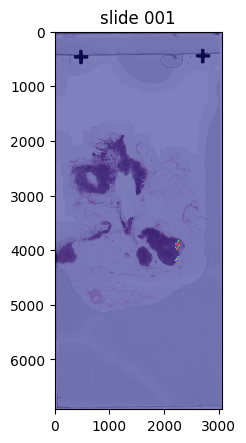

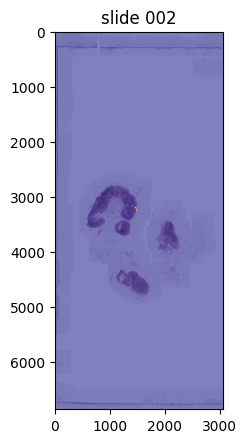

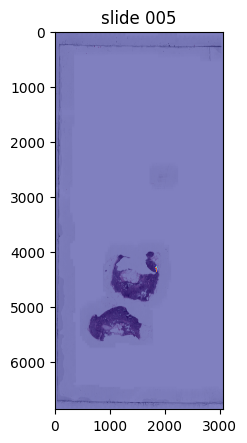

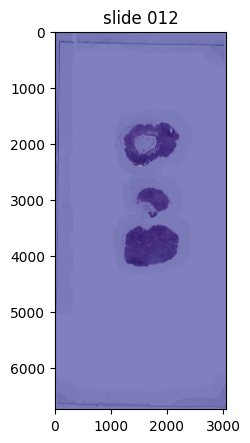

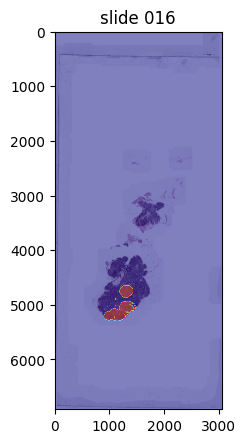

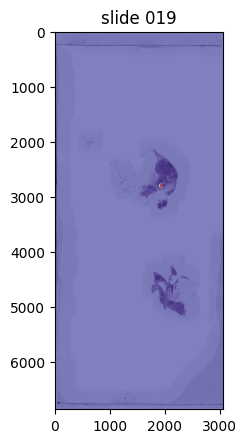

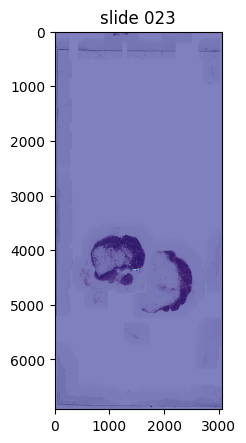

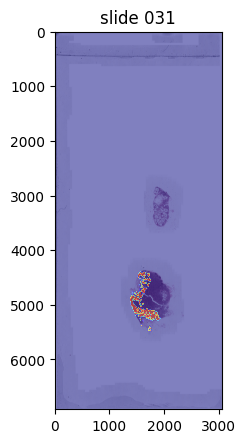

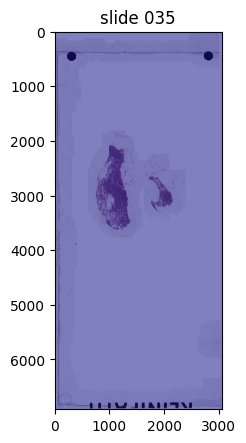

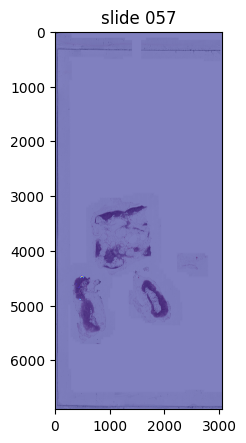

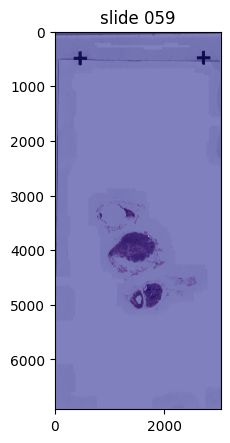

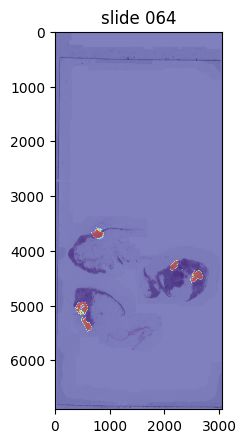

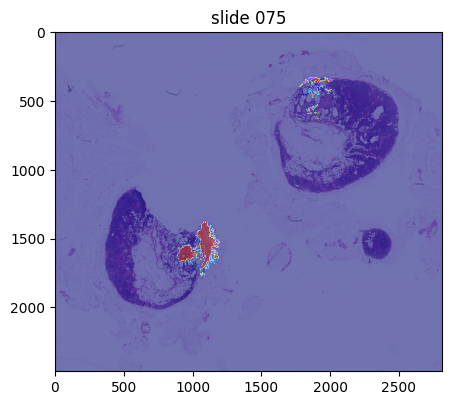

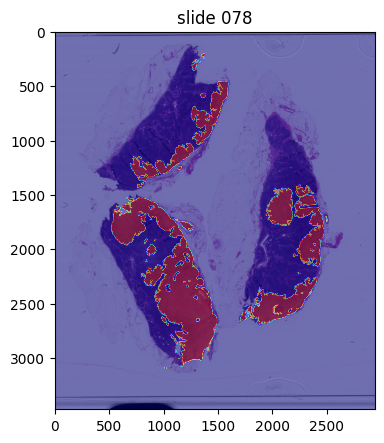

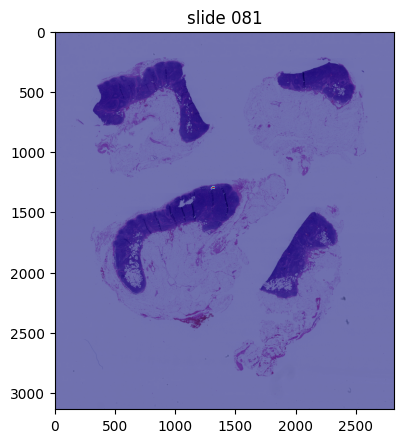

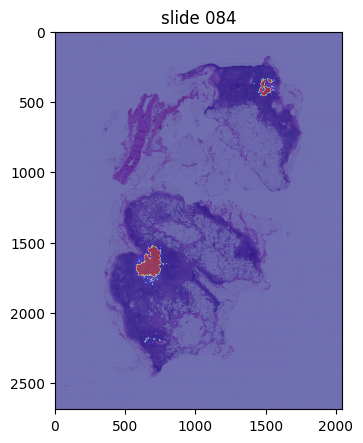

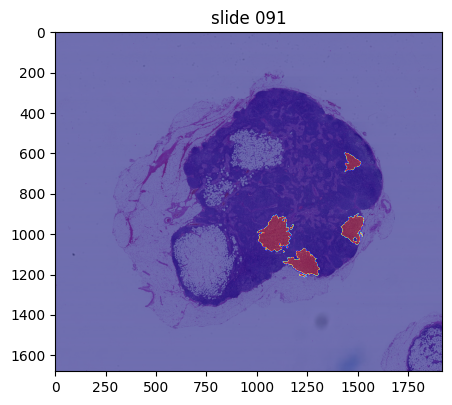

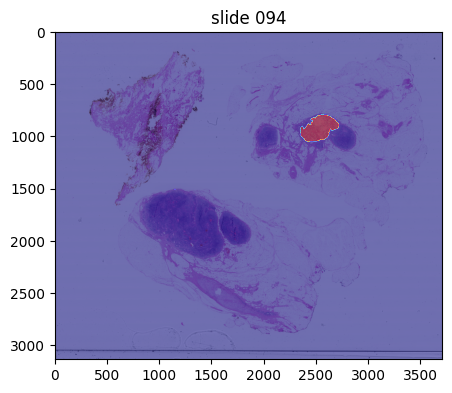

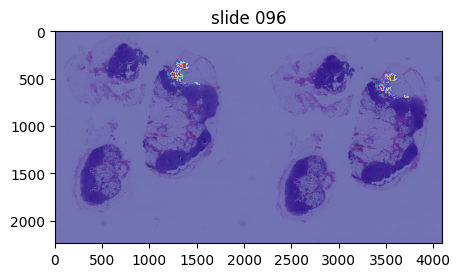

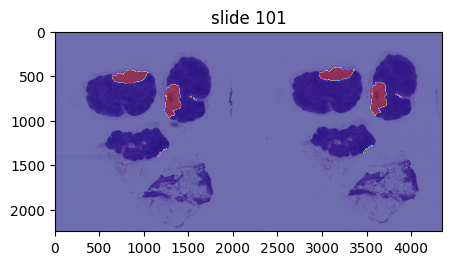

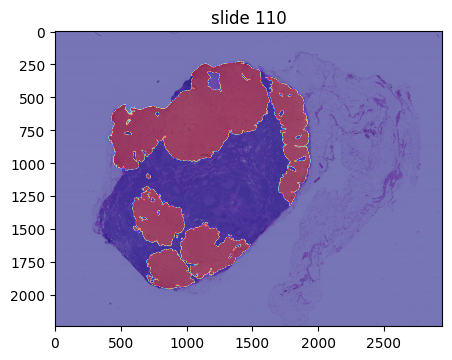

In [38]:
'''
Visualize all the slides, overlay with tumor mask
'''
visualized_level = 5

for img_path, tumor_path in list(zip(all_img_paths, all_mask_paths)):

    slide_image = read_slide(open_slide(str(img_path)), 
                           x=0, 
                           y=0, 
                           level=visualized_level)
    tumor_mask = read_slide(open_slide(str(tumor_path)), 
                           x=0, 
                           y=0, 
                           level=visualized_level)
    '''
    Remove RGB info as the mask information is in the first channel only
    '''
    tumor_mask = tumor_mask[:,:,0]

    plt.figure(figsize=(5,5), dpi=100)
    #set title for each image with python 3 f string
    plt.title(f"slide {img_path.name.split('tumor_')[1].split('.tif')[0]}")
    plt.imshow(slide_image)
    #plt.imshow(tumor_mask)
    plt.imshow(tumor_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.




**Separate train,validation and test sets**

In [39]:
#20211224 temporary settings

'''
test: 096, 075, 091
Validation: 002, 057
Rest are training dataset
'''


#obtain test set
test_image_path = sorted([path_x for path_x in all_img_paths if np.sum([id in str(path_x) for id in ['096', '075', '091']])>0])
test_mask_path = sorted([path_x for path_x in all_mask_paths if np.sum([id in str(path_x) for id in ['096', '075', '091']])>0])

#obtain validation set

val_image_path = sorted([path_x for path_x in all_img_paths if np.sum([id in str(path_x) for id in ['002', '057']])>0])
val_mask_path = sorted([path_x for path_x in all_mask_paths if np.sum([id in str(path_x) for id in ['002', '057']])>0])

#obtain train set
train_image_path = sorted(list(set(all_img_paths) - set(test_image_path) - set(val_image_path)))
train_mask_path = sorted(list(set(all_mask_paths) - set(test_mask_path) - set(val_mask_path)))



In [40]:
#Verify the train, validataion and test sets
print(f'The train image paths are:\n{train_image_path}')
print(f'The train mask paths are:\n{train_mask_path}')


print(f'The validation image paths are:\n{val_image_path}')
print(f'The validation mask paths are:\n{val_mask_path}')


print(f'The test image paths are:\n{test_image_path}')
print(f'The test mask paths are:\n{test_mask_path}')


The train image paths are:
[PosixPath('120319_project_tumor_folder/Copy of tumor_001.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_005.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_012.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_016.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_019.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_023.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_031.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_035.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_059.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_064.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_078.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_081.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_084.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_094.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_101.tif'), PosixPath('1

### <b>Creating the train, validation and test dataset by slice images into different patches with binary labels of 1 (has tumor) or 0 (dost not have); I will repeat this exercise on two zoom levels with highest resolutions (level 0 and level 1)</b> ###


<b>Step 1: Convert paths in the datasets to open_slide objects </b>

In [41]:
def path_to_slide(path):
    return open_slide(str(path))


train_slides = [path_to_slide(path) for path in train_image_path]
train_mask = [path_to_slide(path) for path in train_mask_path]
train_names = [path.name.split("Copy of ")[1] for path in train_image_path]


val_slides = [path_to_slide(path) for path in val_image_path]
val_mask = [path_to_slide(path) for path in val_mask_path]
val_names = [path.name.split("Copy of ")[1] for path in val_image_path]


test_slides = [path_to_slide(path) for path in test_image_path]
test_mask = [path_to_slide(path) for path in test_mask_path]
test_names = [path.name.split("Copy of ")[1] for path in test_image_path]



<b>Step 2: Define functions to extract only tissue pixels from the slides</b>

In [42]:
'''
define function to extract only tissue pixels from image 
in order to improve efficiency / accuracy of the model
'''

#return the location of tissue pixels (2D) in an image slide
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

#return a new image with only tissue pixels showing in red color (255)
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask:
        masked[x][y] = color
    return masked


#function to extract tissues from the slide image, return a new image with only tissue pixels in red color
def extract_tissue(slide_image):
    return(apply_mask(slide_image, find_tissue_pixels(slide_image)))


<b>Step 3 Define function to check if tumor does exist in a center region of a patch obtained from a slide</b>

In [43]:
#check the center region 128*128 of a 299*299 patch, and return the boolean value indicates whether the center region of the patch has tumor or not
#Sum > 0 suggests existence of tumor pixel in the center region
def has_tumor_center_patch(mask, center_size=128, patch_size=299):
    edge = (patch_size - center_size) // 2

    return np.sum(mask[edge:center_size + edge, edge:center_size + edge]) > 0

In [44]:
#define the function to obtain a patch from a slide
def get_patch(slide, tumor_mask, x, y, zoom_level, patch_size = 299):
    x = int(x)
    y = int(y)

    #actual edge is equal to patch_size times corresponding zoom level
    edge = int(patch_size // 2 * slide.level_downsamples[zoom_level])

    #slide read from the Top left corner of the patch
    slide_image = read_slide(slide,
                           x - edge, 
                           y - edge,
                           zoom_level,
                           width=patch_size,
                           height=patch_size)


    #take only the first dimension of [R, B, G] for the mask 
    mask_image = read_slide(tumor_mask,
                           x - edge, 
                           y - edge,
                           zoom_level,
                           width=patch_size,
                           height=patch_size)[:, :, 0]

    return slide_image, mask_image



In [45]:
#function to check if a mask contains tumor and normal pixels
def has_tumor_or_normal_pixels(mask_slide, level=5):
    #read mask slide, take the first of the RGB dimension
    mask = read_slide(mask_slide,
                    0,
                    0,
                    level,
                    width=mask_slide.level_dimensions[level][0],
                    height=mask_slide.level_dimensions[level][1]
                    )[:,:,0]

    #if not all the element in the mask are 1s,there are normal pixels in the slide
    #if sum of all the element in the  mask is >0, there are tumor pixels in the slide
    return np.sum(mask[:,:])!= np.sum(np.ones_like(mask[:,:])), np.sum(mask[:,:]) > 0

<b>Step 4. Define function to obtain patch center for normal and tumor pixels</b>

In [46]:
#Define function to select patch center for tumor and normal pixels
def get_normal_tumor_pixels(slide_image, mask_image, zoom_level=5, patch_size=299):
    
    #trim the edge of images to make sure that the patches slided from the image will not start from the edge of the slide
    trimmed_image = slide_image[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
    trimmed_mask = mask_image[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]

    trimmed_tissue = extract_tissue(trimmed_image)


    #those normal tissues will NOT have red pixel (which indicate tumor)
    tissue_subtract_tumor = trimmed_tissue[:,:,0] - 255* trimmed_mask

    #get iterators for pixels
    normal_pixels = list(zip(*np.where(tissue_subtract_tumor != 0)))
    tumor_pixels = list(zip(*np.where(trimmed_mask != 0)))


    normal_pixels = [(x[1] + patch_size // 2, x[0] + patch_size // 2) for x in normal_pixels]
    tumor_pixels = [(x[1] + patch_size // 2, x[0] + patch_size // 2) for x in tumor_pixels]


    return normal_pixels, tumor_pixels




<b>Step 5. Generate two zoom level results with corresponding labels</b>

In [119]:
import random
import pickle

#function to generate actual 'Data' for modeling
def data_generator(slide_names, tumor_slides, mask_slides, zoom_level_1, zoom_level_2, random_seed = None, 
                   base_zoom_level = 5, num_samples = 3000, patch_size = 299, center_size = 128, \
                   select_from_pixels = True, set_tissue_percentage = 0.3):
    '''
    Definition of parameters:
    slide_name: name of the slides
    tumor_slides: list of tumor slides
    mask_slides: list of mask slides
    zoom_level_1, zoom_level_2: 2 zoom levels will be used for sampling patches
    random_seed: whehter each time run the function, the same subset will be sampled
    base_zoom_level: the best zoom level for visualization of slides (default 5)
    num_samples: number of patches will be generated
    patch_size, center_size the size of each patch and patch center area
    select_from_pixel: if False, it will randomly sample pixels, otherwise, it will sample from pre-calculated pixels
    set_tissue_percentage: the threshold for minimal percentage of tissue contained in a slide
    '''
    if random_seed:
        random.seed(random_seed)
        np.random.seed(random_seed)

    #make sure to sample the same number of normal and tumor pathes 
    #(as tumor areas tend to be significantly less than normal areas in the slide)
    num_normal = num_samples // 2
    num_tumor = num_samples // 2

    normal_slides_with_mask = []
    tumor_slides_with_mask = []

    #assign tumor slides to normal and tumor slides list
    for tumor_slide, mask_slide in zip(tumor_slides, mask_slides):

       
        has_normal, has_tumor = has_tumor_or_normal_pixels(mask_slide)

        if has_normal:
            normal_slides_with_mask.append((tumor_slide, mask_slide))

        if has_tumor:
            tumor_slides_with_mask.append((tumor_slide, mask_slide))


    print(f"Total {len(normal_slides_with_mask)} slides have normal pixels")
    print(f"Total {len(tumor_slides_with_mask)} slides have tumor pixels")

    #perform random sampling based on multinomial distribution with probability 1/n for each of the n slides

    num_normal_patches_each_slide = np.random.multinomial(num_normal, np.repeat(1/len(normal_slides_with_mask), len(normal_slides_with_mask)))
    num_tumor_patches_each_slide = np.random.multinomial(num_tumor, np.repeat(1/len(tumor_slides_with_mask), len(tumor_slides_with_mask)))


    print(f"Numbers of patches sampled on each normal slide is {num_normal_patches_each_slide}")
    print(f"Numbers of patches sampled on each tumor slide is {num_tumor_patches_each_slide}")


    #make sure the total number of patches matches with the total number that needs to be sampled
    assert np.sum(num_normal_patches_each_slide) == num_normal
    assert np.sum(num_tumor_patches_each_slide) == num_tumor


    #obtain zoom level 1, level 2 results and labels

    zoom_level1_result = []
    zoom_level2_result = []
    label = []


    
    #sampling patches from slides
    
    for name, tumor_slide, mask_slide, num_from_tumor, num_from_normal in zip(slide_names, tumor_slides, mask_slides, num_tumor_patches_each_slide, num_normal_patches_each_slide):

    
        print(f"Now working on {name}\n")

        print(tumor_slide)

        slide_image = read_slide(tumor_slide, 
                            x=0,
                            y=0,
                            level=base_zoom_level,
                            width=tumor_slide.level_dimensions[base_zoom_level][0],
                            height=tumor_slide.level_dimensions[base_zoom_level][1]
                            )

        mask_image = read_slide(mask_slide, 
                            x=0,
                            y=0,
                            level=base_zoom_level,
                            width=mask_slide.level_dimensions[base_zoom_level][0],
                            height=mask_slide.level_dimensions[base_zoom_level][1]
                            )[:,:,0]

        #make sure the dimension is correct - slide image and mask are matched corectly
        
        
        assert slide_image.shape[:2] == mask_image.shape

        #select patches

        count_tumor = 0
        count_normal = 0


        if select_from_pixels:
            normal_pixels, tumor_pixels = get_normal_tumor_pixels(slide_image, mask_image, base_zoom_level, patch_size)

        

        #make sure the number requires for both normal and tumor patches is met
        while count_tumor < num_from_tumor or count_normal < num_from_normal:
            if select_from_pixels:
                if count_tumor < num_from_tumor:
                    x, y = random.choice(tumor_pixels)
                elif count_normal < num_from_normal:
                    x, y = random.choice(normal_pixels)

            else: #random select pixels
                x = np.random.randint(patch_size // 2, int(slide_image.shape[1] - patch_size // 2))
                y = np.random.randint(patch_size // 2, int(slide_image.shape[0] - patch_size // 2))


            #map the pixels to the original coordinate
            x = x * tumor_slide.level_downsamples[base_zoom_level]
            y = y * mask_slide.level_downsamples[base_zoom_level]


            patch_image_l1, patch_mask_l1 = get_patch(tumor_slide, mask_slide, x, y, zoom_level_1, patch_size)
            patch_image_l2, patch_mask_l2 = get_patch(tumor_slide, mask_slide, x, y, zoom_level_2, patch_size)

            #check tissue percentage on a larger zoom level (if tissue percetange > 3 when zoomed out (higher level, say 1), 
            # it is suggested that same criteria will met in a subset of the zoomed region (e.g level 0))
            if zoom_level_2 > zoom_level_1:
                tissue_pixels  = find_tissue_pixels(patch_image_l2)
            else:
                tissue_pixels  = find_tissue_pixels(patch_image_l1)

            tissue_percentage = len(list(tissue_pixels)) / patch_size**2

            #get patches and assign proper labels based on whether tumor pixels were observed in the center region of the patch
            #if the center of the subset patch has tumor then the center of the original patch must has tumor
            #only select those patches with tissue percetange no less than the set threshold (default: 0.3)

            

            if has_tumor_center_patch(patch_mask_l1, center_size, patch_size):
                if count_tumor < num_from_tumor and tissue_percentage >= set_tissue_percentage:
                    zoom_level1_result.append(patch_image_l1)
                    zoom_level2_result.append(patch_image_l2)
                    label.append(1)
                    count_tumor += 1
                    

            #label 0 patches
            else:
                if count_normal < num_from_normal and tissue_percentage >= set_tissue_percentage:
                    zoom_level1_result.append(patch_image_l1)
                    zoom_level2_result.append(patch_image_l2)
                    label.append(0)
                    count_normal += 1
                    
            
        #assert required number of patches were sampled
        assert count_normal == num_from_normal
        assert count_tumor == num_from_tumor


      



        print(f'Done sampling {count_tumor} tumor patches and {count_normal} normal patches from slide {name}')

        

    #assert the final number is correct
    assert len(zoom_level1_result) == num_samples
    assert len(zoom_level2_result) == num_samples
    assert len(label) == num_samples



    return zoom_level1_result, zoom_level2_result, label



    














In [120]:
#generate train and validation data at two zoom levels

train_zoom_level1_result, train_zoom_level2_result, train_label = data_generator(train_names, train_slides, train_mask, \
                                                                                 zoom_level_1=0, zoom_level_2=1, random_seed=42, num_samples=4000)


val_zoom_level1_result, val_zoom_level2_result, val_label = data_generator(val_names, val_slides, val_mask, \
                                                                                 zoom_level_1=0, zoom_level_2=1, random_seed=42, num_samples=800)

Total 16 slides have normal pixels
Total 16 slides have tumor pixels
Numbers of patches sampled on each normal slide is [119 127 110 108 139 130 126 135 111 130 127 124 110 120 128 156]
Numbers of patches sampled on each tumor slide is [146 131 116 117 107 121 126 141 144 120 117 130 131 116 111 126]
Now working on tumor_001.tif

OpenSlide('120319_project_tumor_folder/Copy of tumor_001.tif')
Done sampling 146 tumor patches and 119 normal patches from slide tumor_001.tif
Now working on tumor_005.tif

OpenSlide('120319_project_tumor_folder/Copy of tumor_005.tif')
Done sampling 131 tumor patches and 127 normal patches from slide tumor_005.tif
Now working on tumor_012.tif

OpenSlide('120319_project_tumor_folder/Copy of tumor_012.tif')
Done sampling 116 tumor patches and 110 normal patches from slide tumor_012.tif
Now working on tumor_016.tif

OpenSlide('120319_project_tumor_folder/Copy of tumor_016.tif')
Done sampling 117 tumor patches and 108 normal patches from slide tumor_016.tif
Now wo

In [121]:
#save train and validation data
with open('120319_project_tumor_folder/122421_train_cancer_image_patches.pkl', 'wb') as f:
    pickle.dump([train_zoom_level1_result, train_zoom_level2_result, train_label], f)
f.close()


with open('120319_project_tumor_folder/122421_validation_cancer_image_patches.pkl', 'wb') as f:
    pickle.dump([val_zoom_level1_result, val_zoom_level2_result, val_label], f)
f.close()

In [122]:
print("FINISHED!")

FINISHED!


## sanity check on obtained patches

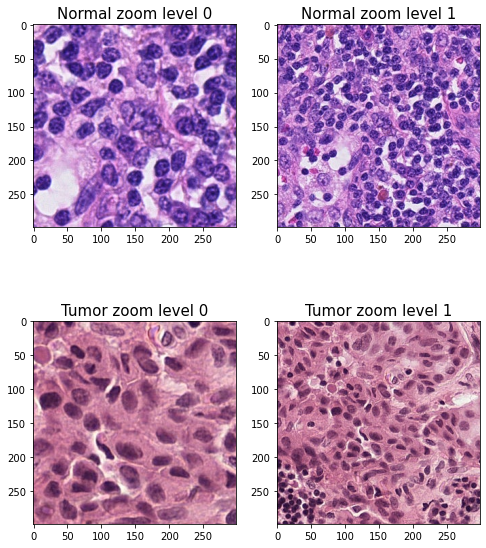

In [125]:
#random sample a batch from train dataset
normal_ind = [i for i in range(len(train_label)) if train_label[i] == 0]
tumor_ind = [i for i in range(len(train_label)) if train_label[i] == 1]


#pick a normal index and a tumor index at random

normal_idx = random.choice(normal_ind)

tumor_idx = random.choice(tumor_ind)



fig, ax = plt.subplots(2, 2, figsize=(8, 10))


ax[0, 0].imshow(train_zoom_level1_result[normal_idx])
ax[0, 0].set_title('Normal zoom level 0', size=15)
ax[0, 1].imshow(train_zoom_level2_result[normal_idx])
ax[0, 1].set_title('Normal zoom level 1', size=15)
ax[1, 0].imshow(train_zoom_level1_result[tumor_idx])
ax[1, 0].set_title('Tumor zoom level 0', size=15)
ax[1, 1].imshow(train_zoom_level2_result[tumor_idx])
ax[1, 1].set_title('Tumor zoom level 1', size=15)

plt.show();


In [129]:
print(f"The number of level 1 patches in train dataset is {len(train_zoom_level1_result)}")
print(f"The number of level 2 patches in train dataset is {len(train_zoom_level2_result)}")
print(f"The number of level 1 patches in validation dataset is {len(val_zoom_level1_result)}")
print(f"The number of level 2 patches in validation dataset is {len(val_zoom_level2_result)}")

The number of level 1 patches in train dataset is 4000
The number of level 2 patches in train dataset is 4000
The number of level 1 patches in validation dataset is 800
The number of level 2 patches in validation dataset is 800
